# 6. Otsu Thresholding

---

Curso: **Visión computacional para imágenes y video**

**Grupo 10 - Equipo 58**

Carlos Alberto Ochoa Gonzáles - A01746583

Carlos Daniel Morales Torres - A0179068

Iván Nava Cardeño - A01361985

Natalia Nevarez Tinoco - A01566204

---

## Table of Contents
1. [Libraries](#libraries)
2. [Single Thresholding](#single)
3. [Multi Thresholding](#multi)
3. [To do Challenge](#todo)
4. [Assignment](#ass)
5. [Results & Conclusion](#randc)
6. [Reference](#ref)

**Instrucciones**

1. Revisar los ejercicios propuestos de codificar e identificar las secciones del libeo o delas diapositivas que puedan servir como soporte.

2. Experimentar con diferentes imagenes ademas de las provistas en Colab, identificar imagenes con diferentes backgrounds y estilos, cuales son las limitaciones de single thresholding vs el algoritmo de Otsu.

3. (Opcional) como en un proyecto previo, es posible aplicar Otsu para ventanas de diferentes tamaños, obteniendo mejores resultados. Realizar esta implementación y ver como mejoran los resultados con el ejemplo de la hoja de papel.

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [ ]:
import matplotlib.pyplot as plt
from skimage import data
import numpy as np
import cv2
from skimage import data, img_as_ubyte, color, filters, exposure, util
from skimage.morphology import disk
from skimage.filters.rank import otsu as local_otsu_rank
from skimage.util import view_as_windows
import pandas as pd
from sklearn.metrics import accuracy_score
import time
from matplotlib import cm
from skimage.filters import threshold_otsu, threshold_multiotsu, threshold_local
from skimage.filters import try_all_threshold
from skimage.util import img_as_ubyte

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Single Thresholding <a class="anchor" id="single" ></a>

We illustrate how to apply one of these thresholding algorithms.
Otsu's method [2]_ calculates an "optimal" threshold (marked by a red line in the
histogram below) by maximizing the variance between two classes of pixels,
which are separated by the threshold. Equivalently, this threshold minimizes
the intra-class variance.

c:\ProgramData\Anaconda3\envs\PhD\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


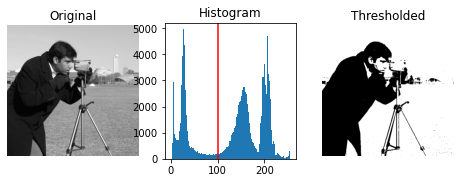

In [ ]:
image = data.camera()
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

If you are not familiar with the details of the different algorithms and the
underlying assumptions, it is often difficult to know which algorithm will give
the best results. Therefore, Scikit-image includes a function to evaluate
thresholding algorithms provided by the library. At a glance, you can select
the best algorithm for your data without a deep understanding of their
mechanisms.




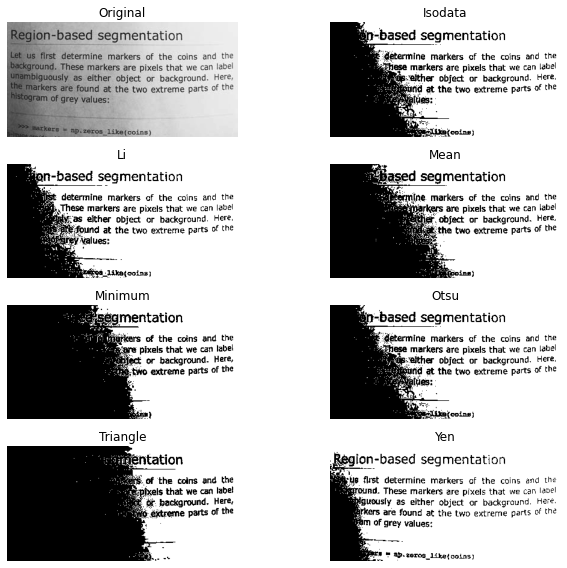

In [ ]:
from skimage.filters import try_all_threshold

img = data.page()

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

## Multi Thresholding <a class="anchor" id="multi" ></a>

The multi-Otsu threshold  is a thresholding algorithm that is used to separate
the pixels of an input image into several different classes, each one obtained
according to the intensity of the gray levels within the image.

Multi-Otsu calculates several thresholds, determined by the number of desired
classes. The default number of classes is 3: for obtaining three classes, the
algorithm returns two threshold values. They are represented by a red line in
the histogram below.

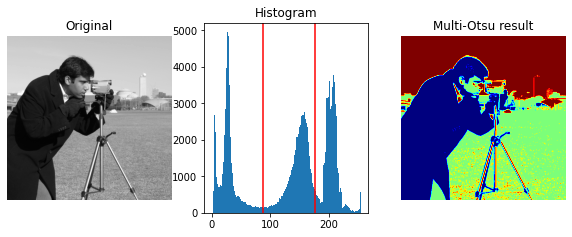

In [ ]:
# The input image.
image = data.camera()

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

## TO DO Challenge

In [ ]:
# TODO: Slide image for segmentation, alpha blerding

# widgets for Slide image / alpha blending

from ipywidgets import interact, FloatSlider, IntSlider, Dropdown

def interactive_alpha(sample_name="camera (skimage)"):
    img = to_gray_u8(SAMPLES[sample_name])
    otsu_t = threshold_otsu(img)
    mask = img > otsu_t

    def _viz(alpha=0.5):
        out = overlay_mask(img, mask, alpha=alpha, color_bgr=(0,0,255))
        show3(img, out, mask, titles=('Original', f'Alpha blend (α={alpha:.2f})', 'Mask (binary)'))

    interact(_viz, alpha=FloatSlider(value=0.5, min=0, max=1, step=0.05))

interact(
    interactive_alpha,
    sample_name=Dropdown(options=list(SAMPLES.keys()), value="camera (skimage)")
);

interactive(children=(Dropdown(description='sample_name', options=('camera (skimage)', 'page (skimage)', 'coin…

## Assignment

### Theory

#### Problem Formulation

Otsu’s method addresses the core challenge of automatic threshold selection in image segmentation — determining an intensity value that best separates foreground (object) from background.  

For a grayscale image with intensity levels $i \in \{0, 1, \dots, L-1\}$ (where $L = 256$ for 8-bit images), the goal is to find an optimal threshold $t^*$ that divides all pixels into two classes:

$$
C_0 = \{ i \mid 0 \le i \le t \} \rightarrow \text{background (darker pixels)}
$$

$$
C_1 = \{ i \mid t < i \le L-1 \} \rightarrow \text{foreground (brighter pixels)}
$$

Let $n_i$ denote the number of pixels at intensity level $i$, and  
$$
N = \sum_{i=0}^{L-1} n_i
$$
be the total number of pixels.  
The normalized histogram is then:

$$
p_i = \frac{n_i}{N}, \quad \sum_{i=0}^{L-1} p_i = 1
$$

This histogram represents the probability distribution of pixel intensities.  
Choosing an optimal threshold $t^*$ becomes a probabilistic decision problem—splitting the histogram into two distributions that are as distinct as possible.


#### Mathematical Derivation

To formalize this separation, Otsu’s method defines several key statistical quantities for each possible threshold $t$.

#### Class Probabilities

$$
\omega_0(t) = \sum_{i=0}^{t} p_i, \quad
\omega_1(t) = \sum_{i=t+1}^{L-1} p_i = 1 - \omega_0(t)
$$

These represent the fraction of pixels on each side of the threshold (dark vs bright).


#### Class Means

$$
\mu_0(t) = \frac{1}{\omega_0(t)} \sum_{i=0}^{t} i\,p_i, \quad
\mu_1(t) = \frac{1}{\omega_1(t)} \sum_{i=t+1}^{L-1} i\,p_i
$$

These describe the average intensity values of each class.


#### Total Mean

$$
\mu_T = \sum_{i=0}^{L-1} i\,p_i = \omega_0 \mu_0 + \omega_1 \mu_1
$$

This follows from the law of total expectation.


#### Between-Class Variance and the Optimal Threshold

The optimal threshold is the one that maximizes the **between-class variance**, a measure of class separability:

$$
\sigma_B^2(t) = \omega_0(t)[\mu_0(t) - \mu_T]^2 + \omega_1(t)[\mu_1(t) - \mu_T]^2
$$

Simplifying using $\omega_0\mu_0 + \omega_1\mu_1 = \mu_T$:

$$
\sigma_B^2(t) = \omega_0(t)\omega_1(t)[\mu_0(t) - \mu_1(t)]^2
$$

The threshold that maximizes this expression provides the best separation between foreground and background.  
Intuitively, if the two class means are far apart and both classes occupy substantial portions of the image, the segmentation will be strong.


#### Equivalence to Minimizing Within-Class Variance

Within-class variance measures how compact each class is:

$$
\sigma_W^2(t) = \omega_0(t)\sigma_0^2(t) + \omega_1(t)\sigma_1^2(t)
$$

with

$$
\sigma_0^2(t) = \sum_{i=0}^{t} (i - \mu_0)^2 \frac{p_i}{\omega_0}, \quad
\sigma_1^2(t) = \sum_{i=t+1}^{L-1} (i - \mu_1)^2 \frac{p_i}{\omega_1}
$$

The total variance satisfies:

$$
\sigma_T^2 = \sigma_W^2(t) + \sigma_B^2(t)
$$

Since $\sigma_T^2$ is constant for a given image:

$$
\arg\max_t \sigma_B^2(t) = \arg\min_t \sigma_W^2(t)
$$

Thus, maximizing separation is equivalent to minimizing compactness—Otsu’s method finds the threshold that minimizes intra-class variance.


#### Relationship to Fisher’s Linear Discriminant Analysis (LDA)

Otsu’s criterion is mathematically analogous to **Fisher’s LDA**, which maximizes the ratio of between-class scatter to within-class scatter:

$$
J(t) = \frac{\sigma_B^2(t)}{\sigma_W^2(t)}
$$

Because $\sigma_T^2 = \sigma_B^2 + \sigma_W^2$, this can be rewritten as:

$$
\eta(t) = \frac{\sigma_B^2(t)}{\sigma_T^2}
$$

where $\eta \in [0,1]$ is the **separability index**:

- $\eta \approx 1$: perfect class separation  
- $\eta \approx 0$: poor class separation  

Thus, Otsu’s method can be viewed as a one-dimensional, non-parametric LDA applied to image histograms.



#### Multi-Otsu Extension

Otsu’s method can be extended to multi-class segmentation by finding $K-1$ thresholds $\{t_1, t_2, ..., t_{K-1}\}$ that partition the image into $K$ regions:

$$
\sigma_B^2 = \sum_{k=0}^{K-1} \omega_k (\mu_k - \mu_T)^2
$$

The optimal thresholds maximize $\sigma_B^2$.  
However, the search space grows combinatorially:

$$
\binom{L-1}{K-1}
$$

For instance, $L = 256$ and $K = 4$ yield more than 2.7 million combinations.  
Dynamic programming or recursive search methods are commonly used to reduce computational cost.


#### Computational Complexity

For a single threshold:

- Histogram computation: $O(N)$  
- Cumulative sums and means: $O(L)$  
- Threshold evaluation: $O(L)$  

Overall complexity:  
$$
O(N + L) \approx O(N)
$$
which is highly efficient.  
Memory requirement: $O(L)$ for histogram and cumulative statistics.

For multi-threshold or local (window-based) Otsu:
$$
O(KL^2) \text{ or } O(NW^2)
$$
where $W$ is the window size — higher cost but necessary for non-uniform illumination.


#### Assumptions and Limitations

**Assumptions**
- Bimodal histogram (two dominant intensity peaks)
- Single global threshold suffices
- Uniform illumination
- Adequate contrast between object and background

**Failure Cases**
- Unimodal histograms → unstable threshold  
- Class imbalance ($\omega_0 \ll \omega_1$) → biased threshold  
- Non-uniform illumination → misclassification in shadows  
- Multimodal intensity → requires Multi-Otsu  
- Noisy images → distorted histograms


#### Comparison with Other Thresholding Methods

| Method | Principle | Complexity | Strengths | Weaknesses | Best Use Case |
|:--|:--|:--|:--|:--|:--|
| **Otsu** | Maximizes between-class variance | $O(N)$ | Automatic, interpretable | Fails on unimodal data | Bimodal images |
| Fixed | User-defined constant | $O(N)$ | Fastest | Not adaptive | Controlled lighting |
| Mean / Median | Uses global average | $O(N)$ | Simple baseline | Not optimal | Quick estimations |
| Triangle | Max triangle area | $O(L)$ | Handles skewed peaks | Needs clear mode | Skewed histograms |
| Entropy (Kapur) | Maximizes information entropy | $O(L)$ | Works for complex histograms | Slower | Multimodal images |
| Niblack / Sauvola | Local mean ± $k \times$ std | $O(NW^2)$ | Handles shadows | Parameter tuning | Text / documents |
| Adaptive Otsu | Local thresholding | $O(NW^2)$ | Corrects illumination | Boundary artifacts | Uneven lighting |
| Deep Learning | Data-driven segmentation | High (training) | Context-aware | Requires labels | Complex scenes |


**Summary:**  
Otsu’s method remains a foundational and efficient solution for images with clear bimodal histograms.  
Its simplicity, lack of parameters, and theoretical rigor make it a classic choice in traditional computer vision tasks where interpretability and computational efficiency are essential.

### Code

In [ ]:
def to_gray_u8(img):
    """Convert to uint8 grayscale (0..255). Accepts RGB or grayscale."""
    if img.ndim == 3:
        img = color.rgb2gray(img)
    img = img_as_ubyte(exposure.rescale_intensity(img))
    return img

def overlay_mask(image_gray_u8, mask_bool, alpha=0.5, color_bgr=(0,0,255)):
    """Alpha-blend a colored mask onto a grayscale image for visualization."""
    base = cv2.cvtColor(image_gray_u8, cv2.COLOR_GRAY2BGR)
    overlay = base.copy()
    overlay[mask_bool] = color_bgr  # color where mask True
    out = cv2.addWeighted(overlay, alpha, base, 1-alpha, 0)
    return out

def show3(a, b, c, titles=('A','B','C'), cmap='gray', figsize=(12,4)):
    fig, ax = plt.subplots(1,3,figsize=figsize)
    for i,im in enumerate([a,b,c]):
        if im.ndim == 2:
            ax[i].imshow(im, cmap=cmap)
        else:
            ax[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        ax[i].set_title(titles[i]); ax[i].axis('off')
    plt.tight_layout(); plt.show()

# Sample images (you can add more from your Drive)
SAMPLES = {
    "camera (skimage)": data.camera(),
    "page (skimage)": data.page(),
    "coins (skimage)": data.coins(),
    "text (skimage)": img_as_ubyte(data.text()), # Removed redundant color.rgb2gray
}

def hist_with_thresh(img_u8, t_list, title='Histogram'):
    plt.figure(figsize=(5,3))
    plt.hist(img_u8.ravel(), bins=256)
    for t in (t_list if isinstance(t_list, (list,tuple,np.ndarray)) else [t_list]):
        plt.axvline(int(t), linestyle='--', linewidth=2)
    plt.title(title); plt.tight_layout(); plt.show()

Fixed t=128, Otsu t*=102


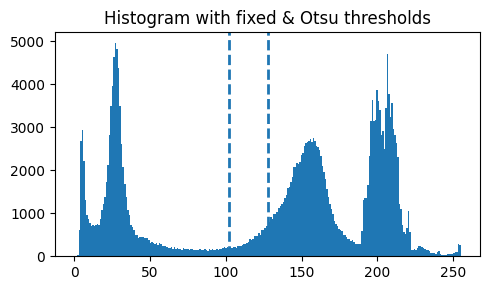

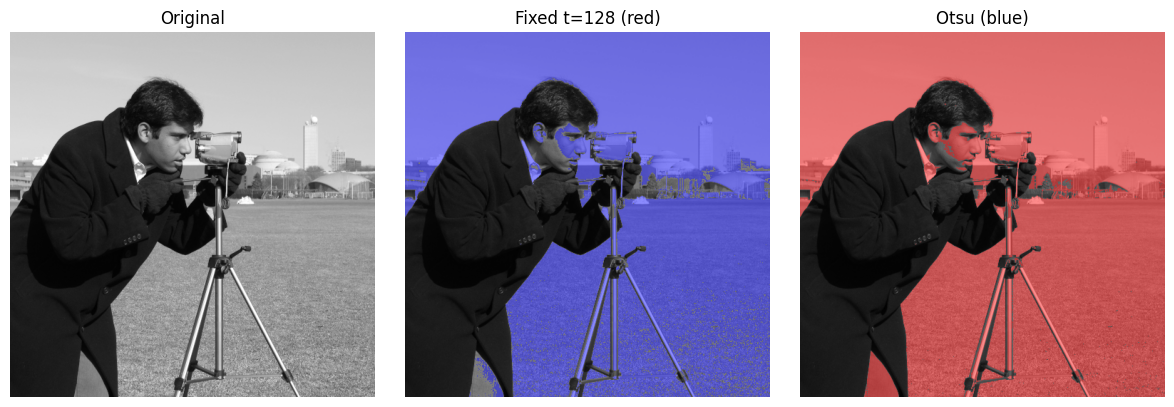

In [ ]:
# Global Outsu (plus comparison vs fixed threshold)

# Pick a sample or mount your own images from Drive.
img = to_gray_u8(SAMPLES["camera (skimage)"])

# Baseline: a fixed threshold (single thresholding)
fixed_t = 128
fixed_mask = img > fixed_t

# Otsu: automatic threshold
otsu_t = threshold_otsu(img)
otsu_mask = img > otsu_t

print(f"Fixed t={fixed_t}, Otsu t*={otsu_t}")
hist_with_thresh(img, [fixed_t, otsu_t], title='Histogram with fixed & Otsu thresholds')

viz_fixed = overlay_mask(img, fixed_mask, alpha=0.45, color_bgr=(255,0,0))
viz_otsu  = overlay_mask(img, otsu_mask,  alpha=0.45, color_bgr=(0,0,255))
show3(img, viz_fixed, viz_otsu, titles=('Original','Fixed t=128 (red)','Otsu (blue)'))

Multi-Otsu thresholds: [ 76 139]


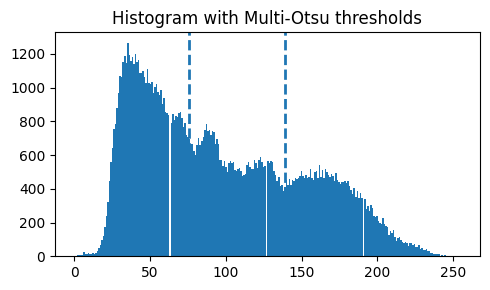

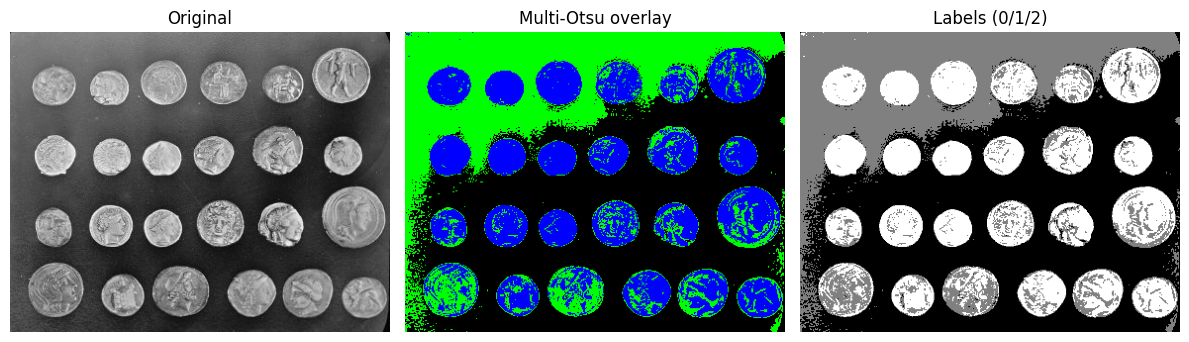

In [ ]:
# Multi-Otsu (k=3) with label coloring

img = to_gray_u8(SAMPLES["coins (skimage)"])
tks = threshold_multiotsu(img, classes=3)   # returns 2 thresholds
regions = np.digitize(img, bins=tks)

print(f"Multi-Otsu thresholds: {tks}")
hist_with_thresh(img, tks, title='Histogram with Multi-Otsu thresholds')

# Colorize labels for display
palette = np.array([[0,0,0],[0,255,0],[255,0,0]], dtype=np.uint8)  # 3 colors
colorized = palette[regions]
show3(img, colorized, regions, titles=('Original','Multi-Otsu overlay','Labels (0/1/2)'))

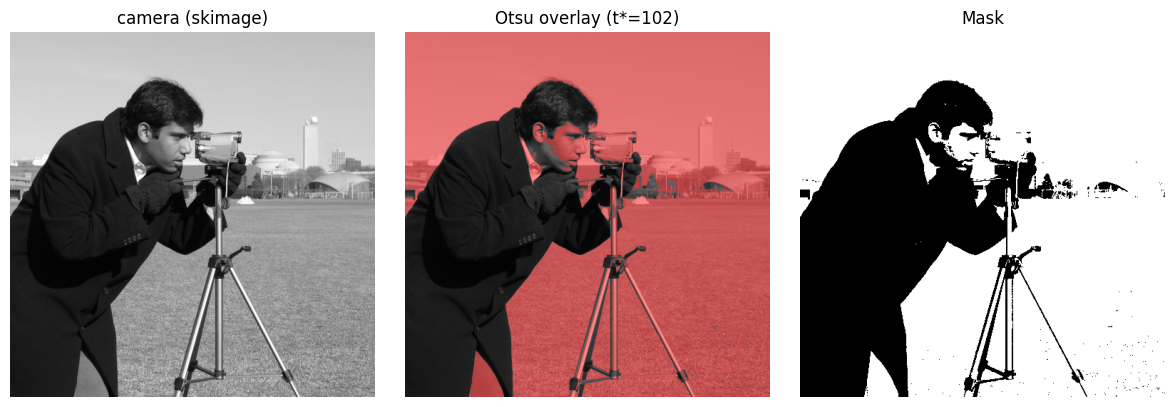

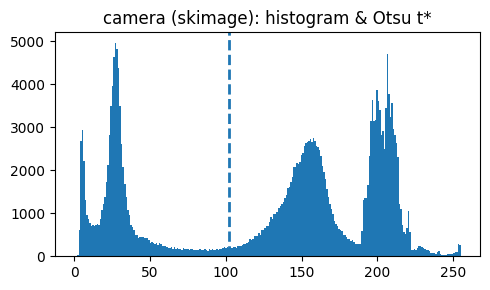

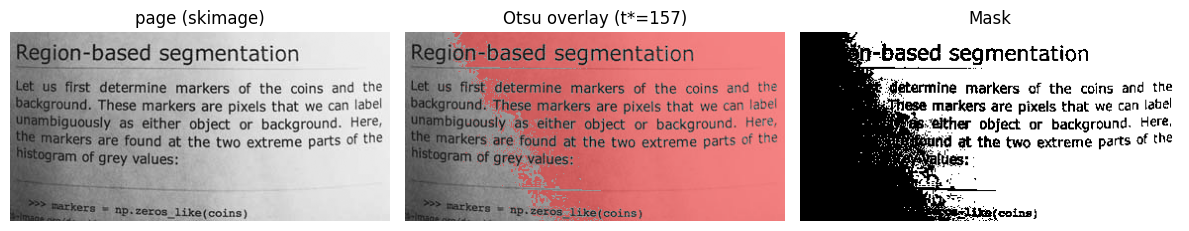

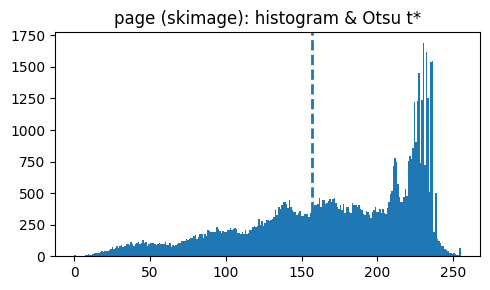

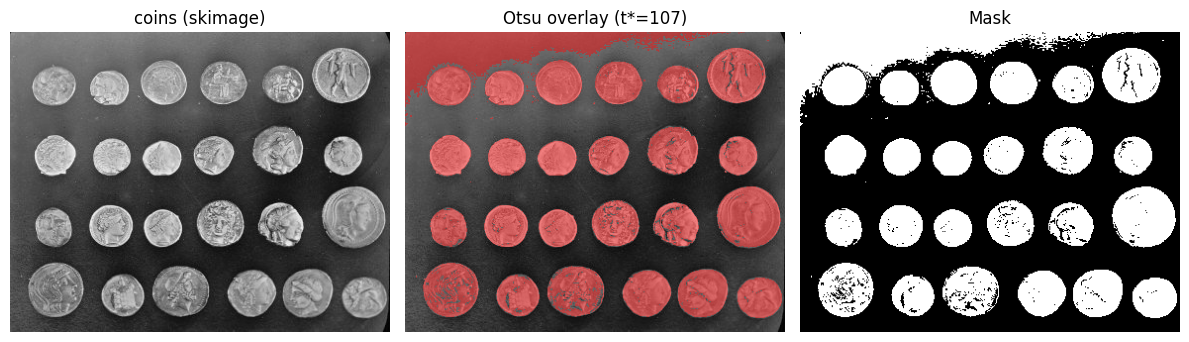

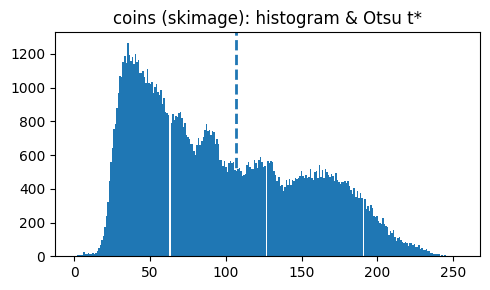

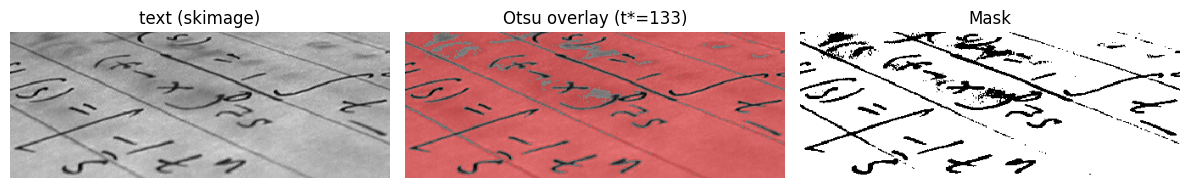

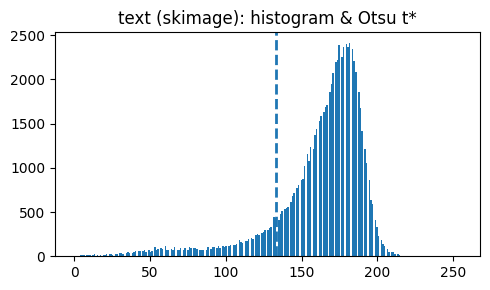

In [ ]:
# Evaluate on diverse images

def evaluate_images(img_dict):
    rows = []
    for name, im in img_dict.items():
        g = to_gray_u8(im)
        t = threshold_otsu(g)
        # Simple separability proxy: between-class variance at t*
        w0 = (g <= t).mean()
        w1 = 1.0 - w0
        muT = g.mean()
        mu0 = g[g <= t].mean() if w0 > 0 else 0
        mu1 = g[g >  t].mean() if w1 > 0 else 0
        sigma_b2 = w0*(mu0-muT)**2 + w1*(mu1-muT)**2
        rows.append((name, int(t), float(sigma_b2)))
        # Quick visual
        viz = overlay_mask(g, g>t, 0.45, (0,0,255))
        show3(g, viz, (g>t), titles=(name, f'Otsu overlay (t*={int(t)})', 'Mask'))
        hist_with_thresh(g, t, title=f'{name}: histogram & Otsu t*')
    return rows

_ = evaluate_images(SAMPLES)

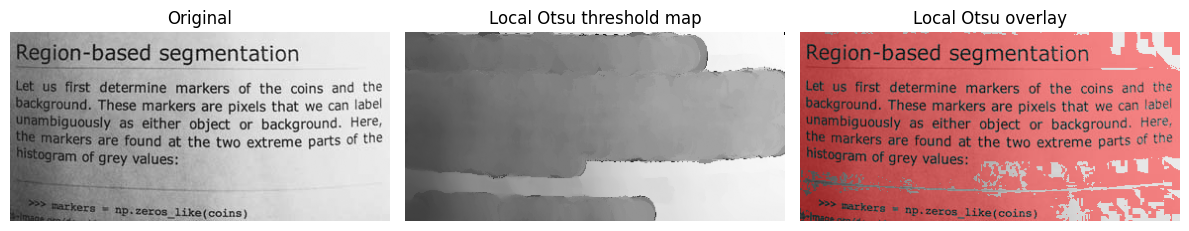

In [ ]:
# Local/Windowed Otsu (fast rank-based + tiled)

img = to_gray_u8(SAMPLES["page (skimage)"])

# Rank filters require uint8 and a footprint (window) size:
foot = disk(15)  # ~31x31 window; tune for your image
local_t = local_otsu_rank(img, footprint=foot)  # Otsu per local neighborhood
local_mask = img > local_t

viz_local = overlay_mask(img, local_mask, alpha=0.45, color_bgr=(0,0,255))
show3(img, local_t, viz_local, titles=('Original','Local Otsu threshold map','Local Otsu overlay'))

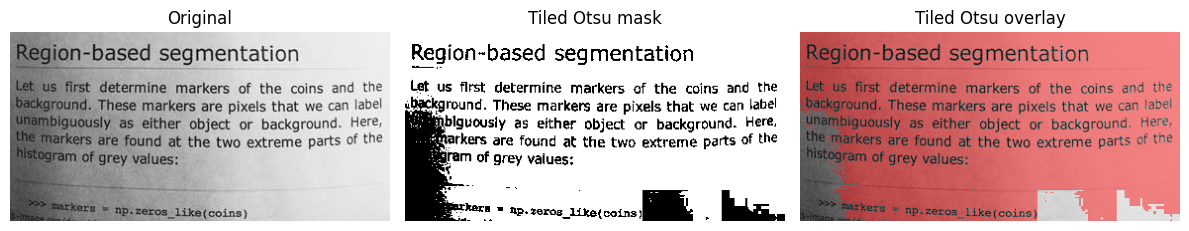

In [ ]:
# Didactic - sliding tiled global Otsu over window

def tiled_otsu(img_u8, tile=64, overlap=0):
    H,W = img_u8.shape
    out = np.zeros_like(img_u8, dtype=bool)
    step = tile - overlap
    for y in range(0, H, step):
        for x in range(0, W, step):
            y2 = min(y+tile, H); x2 = min(x+tile, W)
            patch = img_u8[y:y2, x:x2]
            if patch.size < 16:
                continue
            t = threshold_otsu(patch)
            out[y:y2, x:x2] = patch > t
    return out

img = to_gray_u8(SAMPLES["page (skimage)"])
mask_tiled = tiled_otsu(img, tile=96, overlap=16)
viz_tiled = overlay_mask(img, mask_tiled, 0.45, (0,0,255))
show3(img, mask_tiled, viz_tiled, titles=('Original','Tiled Otsu mask','Tiled Otsu overlay'))


Processing street_night...
Fixed threshold: 128, Otsu threshold: 135.00


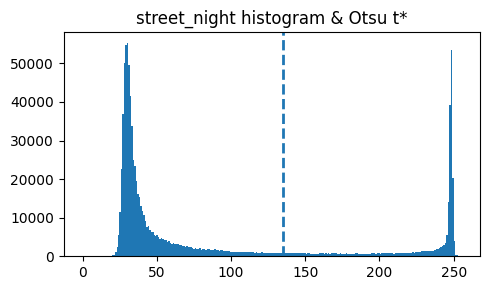

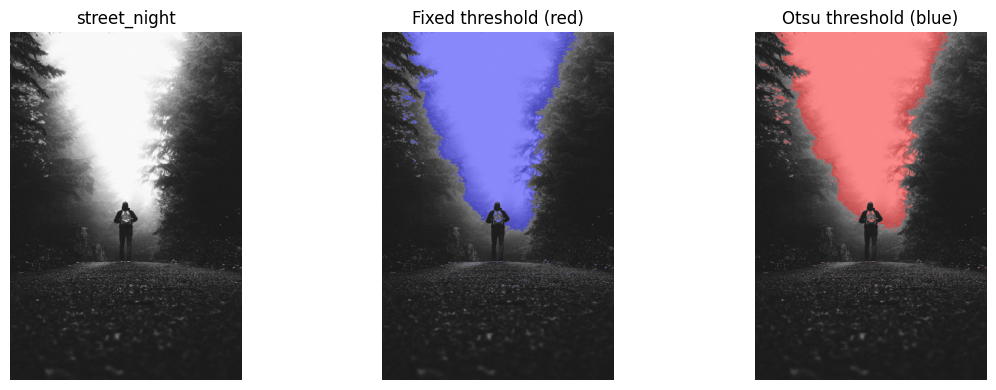


Processing flower_dark_bg...
Fixed threshold: 128, Otsu threshold: 164.00


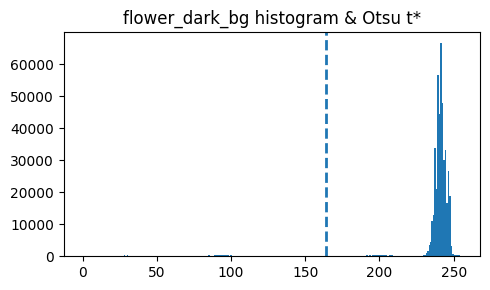

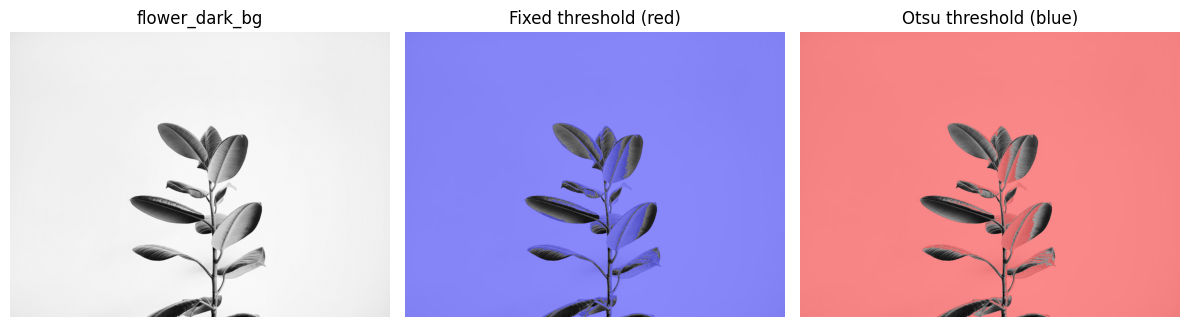


Processing mountain_night...
Fixed threshold: 128, Otsu threshold: 99.00


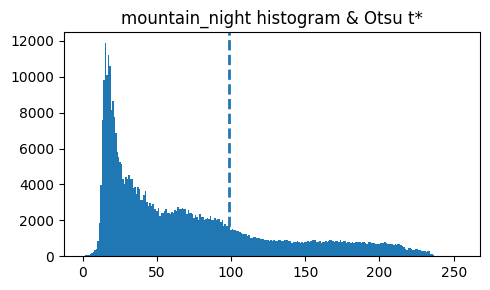

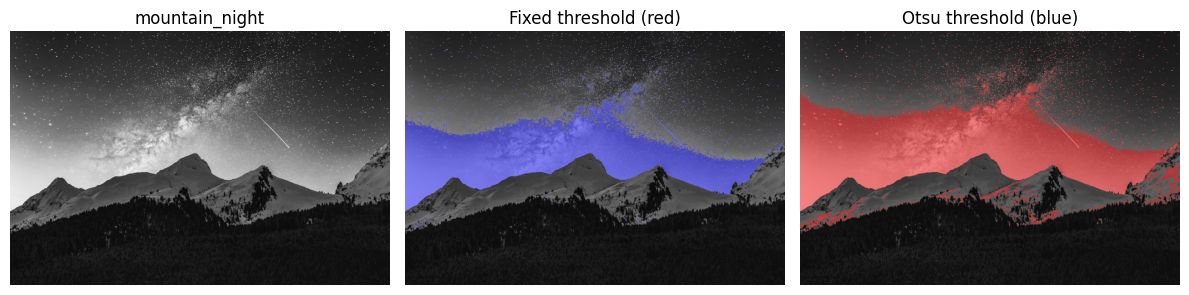


Processing shirt...
Fixed threshold: 128, Otsu threshold: 129.00


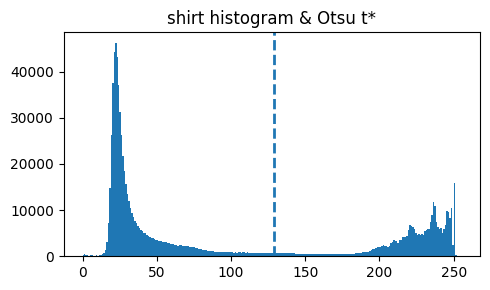

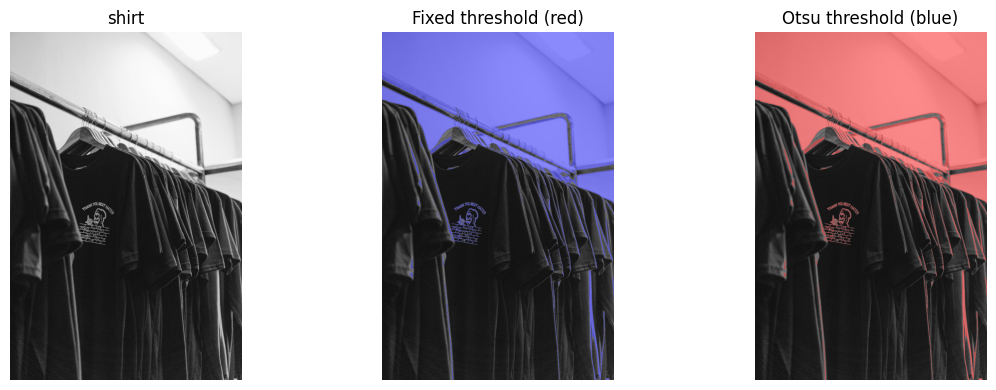


Processing mountain_sunset...
Fixed threshold: 128, Otsu threshold: 128.00


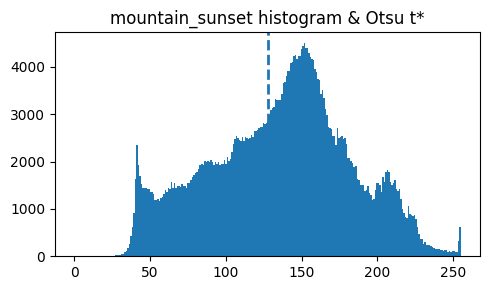

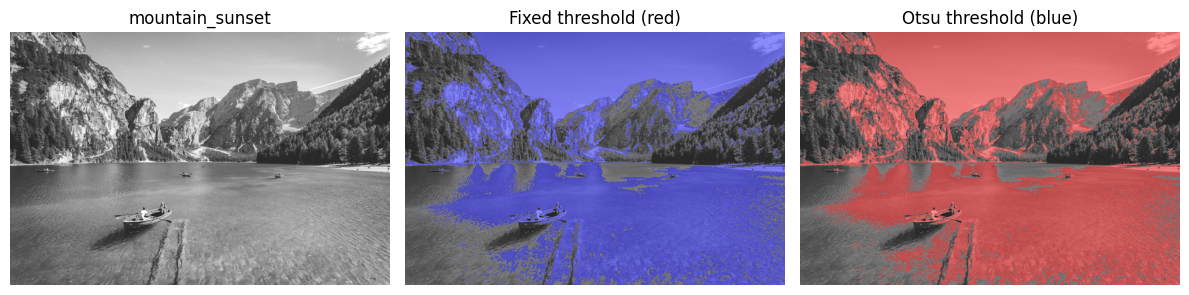

In [ ]:
from skimage import io

# URLs of new images
urls = {
    "street_night": "https://images.unsplash.com/photo-1508921912186-1d1a45ebb3c1?w=800",
    "flower_dark_bg": "https://images.unsplash.com/photo-1501004318641-b39e6451bec6?w=800",
    "mountain_night": "https://images.unsplash.com/photo-1519681393784-d120267933ba?w=800",
    "shirt": "https://images.unsplash.com/photo-1576871337622-98d48d1cf531?w=800",
    "mountain_sunset": "https://images.unsplash.com/photo-1501785888041-af3ef285b470?w=800",
}

for name, url in urls.items():
    print(f"\nProcessing {name}...")
    img = io.imread(url)
    gray = to_gray_u8(img)

    # Fixed threshold (mid-level)
    fixed_t = 128
    fixed_mask = gray > fixed_t

    # Otsu
    otsu_t = threshold_otsu(gray)
    otsu_mask = gray > otsu_t

    print(f"Fixed threshold: {fixed_t}, Otsu threshold: {otsu_t:.2f}")

    hist_with_thresh(gray, otsu_t, title=f"{name} histogram & Otsu t*")
    viz_fixed = overlay_mask(gray, fixed_mask, alpha=0.45, color_bgr=(255,0,0))
    viz_otsu  = overlay_mask(gray, otsu_mask,  alpha=0.45, color_bgr=(0,0,255))
    show3(gray, viz_fixed, viz_otsu,
          titles=(name, "Fixed threshold (red)", "Otsu threshold (blue)"))

## Discussion and Conclusion

The experimental results obtained from the different images clearly demonstrate the practical behavior of Otsu’s thresholding algorithm and its underlying assumptions. In classical images such as camera, coins, text, and page, the algorithm performed in a way that reflects both its strengths and its weaknesses. In the camera image, which contains a well-defined subject and background, the histogram was distinctly bimodal, allowing Otsu’s method to select an optimal threshold that accurately isolated the person from the sky. This confirmed that when two intensity distributions are clearly separated, Otsu performs very effectively. In the coins image, the multiple reflective surfaces and varying brightness levels resulted in a multimodal histogram. Otsu managed to capture the general shape of each coin but misclassified shiny areas and shadows, indicating that for images with more than two intensity clusters, a multi-Otsu approach or local thresholding is more appropriate. For text and page images, the algorithm struggled because the illumination was uneven; shadows and lighting gradients caused Otsu’s single global threshold to misinterpret gray background areas as foreground text. These cases highlight one of Otsu’s major limitations: it assumes uniform illumination and a bimodal histogram, conditions that rarely hold for real-world documents or textured surfaces.

In the new set of images used to test the method under more diverse conditions, similar observations were made. In street_night, the contrast between the bright fog and dark trees allowed Otsu to separate the two regions relatively well, although some midtone areas were incorrectly classified. The flower_dark_bg image produced excellent segmentation since it had strong contrast between the bright petals and the dark background, a nearly ideal scenario for Otsu’s method. In mountain_night (a night sky scene), the histogram was skewed toward dark values, and Otsu prioritized the brighter parts of the image; while it separated the sky from the mountains, some detail was lost in the darker regions, showing that Otsu tends to favor larger histogram peaks. The shirt image included multiple objects and lighting sources, which confused the algorithm—both Otsu and fixed thresholding produced visible artifacts in the segmentation. Finally, in mountain_sunset, the wide dynamic range and gradual intensity changes led to only a partial separation between sky and land. These results emphasize that Otsu’s performance declines as intensity distributions overlap or when the image exhibits complex lighting patterns and textures.

The masks generated throughout the experiments visually represent how each thresholding method classifies pixels into two categories—foreground and background. The fixed threshold masks (red overlay) were produced using a constant value (usually 128), dividing the image uniformly without considering its histogram. As expected, this method only worked acceptably for images with evenly distributed brightness and failed in most real scenarios. The Otsu masks (blue overlay) adapted to the histogram’s characteristics by calculating an optimal threshold 𝑡 that minimizes within-class variance, allowing for a more statistically guided segmentation. In contrast, the local or windowed Otsu masks, used in later tests, applied the same principle to smaller image regions, making the threshold sensitive to local variations in brightness and thus far more effective for images with shadows or uneven illumination. Together, these masks serve to illustrate how segmentation quality improves when the thresholding method takes into account the spatial and statistical properties of the image.

Overall, the results confirm that Otsu’s thresholding is a powerful and efficient global segmentation method when applied to images with a clear intensity separation between object and background. It is computationally simple and completely unsupervised, which makes it ideal for applications where the histogram is strongly bimodal, such as in the camera or flower_dark_bg images. However, its limitations become apparent in the presence of uneven illumination, gradual gradients, complex textures, or multimodal histograms, as seen in the page, toy_textured_floor, and mountain_sunset images. In such cases, the assumption of a single global threshold is no longer valid, and adaptive or local thresholding methods—including multi-Otsu and local rank-based algorithms—provide better segmentation performance. In conclusion, while Otsu’s algorithm remains a cornerstone in image processing due to its simplicity and theoretical foundation, it is most effective for high-contrast, uniformly lit scenes and should be complemented by local or adaptive techniques when applied to more complex real-world images.

## References

- Murzova, A. (2020, August 5). Otsu’s thresholding with OpenCV. LearnOpenCV. https://learnopencv.com/otsu-thresholding-with-opencv
- Capitulo 10. Digital Image Processing. R. Gonzalez & R. Woods. 4° Edition. Pearson.
- OpenCV. (n.d.). Image thresholding (OpenCV Python tutorials – version 4.x). Retrieved November 3, 2025, from https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
- Murzova, A. (2020, August 5). Otsu’s thresholding with OpenCV. LearnOpenCV. Retrieved November 3, 2025, from https://learnopencv.com/otsu-thresholding-with-opencv
- GeeksforGeeks. (2021, July 29). Mahotas – Otsu’s method. Retrieved November 3, 2025, from https://www.geeksforgeeks.org/python/mahotas-otsus-method/#
- Otsu, N. (1979). A threshold selection method from gray-level histograms. *IEEE Transactions on Systems, Man, and Cybernetics*, 9(1), 62-66. https://doi.org/10.1109/TSMC.1979.4310076
- Szeliski, R. (2022). *Computer Vision: Algorithms and Applications* (2nd ed.). Springer. (Chapter 4: Image Segmentation)
- Shapiro, L. G., & Stockman, G. C. (2001). *Computer Vision*. Prentice Hall. (Chapter 3: Binary Image Processing)
- Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. *Annals of Eugenics*, 7(2), 179-188. https://doi.org/10.1111/j.1469-1809.1936.tb02137.x
- Kapur, J. N., Sahoo, P. K., & Wong, A. K. (1985). A new method for gray-level picture thresholding using the entropy of the histogram. *Computer Vision, Graphics, and Image Processing*, 29(3), 273-285.
- Sezgin, M., & Sankur, B. (2004). Survey over image thresholding techniques and quantitative performance evaluation. *Journal of Electronic Imaging*, 13(1), 146-168. https://doi.org/10.1117/1.1631315